<a href="https://colab.research.google.com/github/thomasjuin1/EmotionClassification/blob/twitter-dataset/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from datasets import load_dataset
import torch.nn as nn
import torch.optim as optim

In [3]:
# Load the dataset
dataset = load_dataset("dair-ai/emotion", "split")

# Split into train, validation, and test sets
train_set = dataset["train"]
val_set = dataset["validation"]
test_set = dataset["test"]

train_sset = train_set.map(lambda x: {"text": x["text"], "labels": [x["label"]]})
val_sset = val_set.map(lambda x: {"text": x["text"], "labels": [x["label"]]})
test_sset = test_set.map(lambda x: {"text": x["text"], "labels": [x["label"]]})

__emotions = [
    "sadness",
    "joy",
    "love",
    "anger",
    "fear",
    "surprise",
]

EMOTION_TO_INDEX = {
    emotion: index for index, emotion in enumerate(__emotions)
}

INDEX_TO_EMOTION = {
    index: emotion for emotion, index in EMOTION_TO_INDEX.items()
}

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [4]:
import spacy
nlp = spacy.load("en_core_web_sm")

def tokenize(text: str) -> list[str]:
    tokens = nlp(text)
    return [token.lemma_.lower().strip() for token in tokens if not token.is_stop]

def build_vocab(texts, max_vocab_size):
    from collections import Counter
    counter = Counter(token for text in texts for token in tokenize(text))
    most_common = counter.most_common(max_vocab_size - 2)
    vocab = {word: idx + 2 for idx, (word, _) in enumerate(most_common)}  # Reserve 0 and 1
    vocab["<PAD>"] = 0
    vocab["<UNK>"] = 1
    return vocab

def encode(text, vocab, max_len):
    tokens = tokenize(text)
    ids = [vocab.get(token, vocab["<UNK>"]) for token in tokens]
    if len(ids) > max_len:
        return ids[:max_len]
    return ids + [vocab["<PAD>"]] * (max_len - len(ids))

In [5]:
# Build vocabulary
all_texts = train_set["text"]
VOCAB_SIZE = 10000
MAX_LEN = 50
vocab = build_vocab(all_texts, VOCAB_SIZE)

In [6]:
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        input_ids = torch.tensor(encode(text, self.vocab, self.max_len), dtype=torch.long)
        return {
            "input_ids": input_ids,
            "labels": torch.tensor(label, dtype=torch.long),
        }

In [7]:
# Prepare datasets
train_dataset = EmotionDataset(train_set["text"], train_set["label"], vocab, MAX_LEN)
val_dataset = EmotionDataset(val_set["text"], val_set["label"], vocab, MAX_LEN)
test_dataset = EmotionDataset(test_set["text"], test_set["label"], vocab, MAX_LEN)

# DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

NUM_CLASSES = len(set(train_set["label"]))  # Number of unique emotions

In [18]:
class LSTM(nn.Module):
    def __init__(self, embed_dim: int, dropout_p: float = 0.1):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(VOCAB_SIZE, embed_dim)
        self.lstm = nn.LSTM(embed_dim, embed_dim, batch_first=True)
        self.fc = nn.Linear(embed_dim, NUM_CLASSES)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))  # (B, T) -> (B, T, E)
        output, (h_n, c_n) = self.lstm(embedded)    # (B, T, H), (1, B, H)

      # Use mean pooling over the sequence length (time steps)
        avg_hidden = output.mean(dim=1)  # (B, H)

        logits = self.fc(avg_hidden)  # Get logits for CrossEntropyLoss
        return logits  # Return only the logits

In [20]:
use_gpu = torch.cuda.is_available()
DEVICE = 'cuda' if use_gpu else 'cpu'
print(f"Using : {DEVICE}")

model = LSTM(embed_dim=128, dropout_p=0.2)
model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using : cuda


In [21]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    print("Training the model")
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            input_ids = batch["input_ids"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        val_preds, val_labels = [], []
        with torch.no_grad():
            print ("Validating the model")
            for batch in val_loader:
                input_ids = batch["input_ids"].to(DEVICE)
                labels = batch["labels"].to(DEVICE)

                outputs = model(input_ids)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                val_preds.extend(preds)
                val_labels.extend(labels.cpu().numpy())

        print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
        # val_acc = accuracy_score(val_labels, val_preds)
        # print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")

train_model(model, train_loader, val_loader, criterion, optimizer, 10)


Training the model
Validating the model
Epoch 1: Train Loss = 724.4754, Val Loss = 67.1081
Validating the model
Epoch 2: Train Loss = 368.3957, Val Loss = 30.7904
Validating the model
Epoch 3: Train Loss = 201.1305, Val Loss = 21.2404
Validating the model
Epoch 4: Train Loss = 137.5794, Val Loss = 18.5158
Validating the model
Epoch 5: Train Loss = 101.7877, Val Loss = 17.0205
Validating the model
Epoch 6: Train Loss = 83.9743, Val Loss = 16.0217
Validating the model
Epoch 7: Train Loss = 66.2481, Val Loss = 15.7143
Validating the model
Epoch 8: Train Loss = 57.3378, Val Loss = 15.3832
Validating the model
Epoch 9: Train Loss = 48.0237, Val Loss = 15.1055
Validating the model
Epoch 10: Train Loss = 42.1222, Val Loss = 16.1351


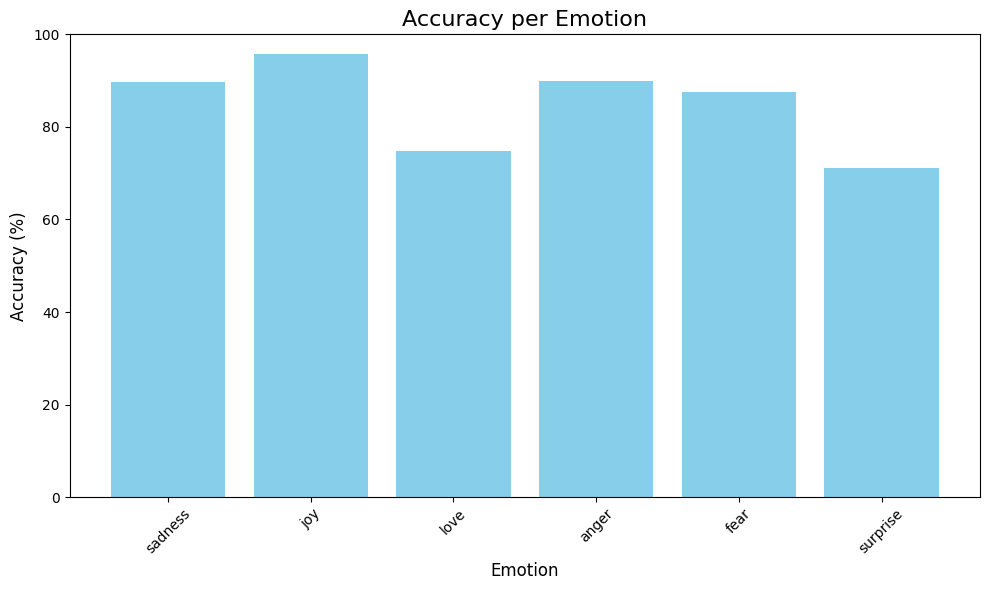

Overall Accuracy: 89.75%
Accuracy per emotion:
sadness: 89.67%
joy: 95.68%
love: 74.84%
anger: 89.82%
fear: 87.50%
surprise: 71.21%


In [22]:
from collections import defaultdict
import matplotlib.pyplot as plt

def evaluate_model(model, data_loader, index_to_emotion, device):
    """
    Evaluate the model and compute accuracy per emotion.

    Args:
        model: The trained model.
        data_loader: DataLoader for the evaluation set.
        index_to_emotion: A dictionary mapping label indices to emotion names.
        device: The device to run the evaluation on.

    Returns:
        A dictionary with emotion-wise accuracy and a plot.
    """
    model.eval()
    emotion_correct = defaultdict(int)
    emotion_total = defaultdict(int)
    total_correct = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            labels = labels.cpu().numpy()

            # Update overall accuracy counts
            total_correct += (preds == labels).sum()
            total_predictions += len(labels)

            # Update emotion-specific counts
            for true_label, pred_label in zip(labels, preds):
                true_emotion = index_to_emotion[true_label]
                predicted_emotion = index_to_emotion[pred_label]
                emotion_total[true_emotion] += 1
                if true_emotion == predicted_emotion:
                    emotion_correct[true_emotion] += 1

    # Calculate overall accuracy manually
    overall_accuracy = (total_correct / total_predictions) * 100 if total_predictions > 0 else 0

    # Calculate accuracy per emotion
    emotion_accuracy = {
        emotion: (emotion_correct[emotion] / emotion_total[emotion] * 100)
        if emotion_total[emotion] > 0 else 0
        for emotion in index_to_emotion.values()
    }

    # Plot accuracy per emotion
    plt.figure(figsize=(10, 6))
    plt.bar(emotion_accuracy.keys(), emotion_accuracy.values(), color="skyblue")
    plt.title("Accuracy per Emotion", fontsize=16)
    plt.xlabel("Emotion", fontsize=12)
    plt.ylabel("Accuracy (%)", fontsize=12)
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

    # Print the results
    print(f"Overall Accuracy: {overall_accuracy:.2f}%")
    print("Accuracy per emotion:")
    for emotion, accuracy in emotion_accuracy.items():
        print(f"{emotion}: {accuracy:.2f}%")

    return emotion_accuracy


# Evaluate the trained model
emotion_accuracy = evaluate_model(
    model=model,
    data_loader=test_loader,
    index_to_emotion=INDEX_TO_EMOTION,
    device=DEVICE
)

In [32]:
for index in range(10):
  current_batch = test_loader.dataset[index]
  print(test_set[index])
  predicted = model(current_batch["input_ids"].unsqueeze(0).to(DEVICE)).argmax(dim=1).item()
  print(INDEX_TO_EMOTION[predicted])

{'text': 'im feeling rather rotten so im not very ambitious right now', 'label': 0}
sadness
{'text': 'im updating my blog because i feel shitty', 'label': 0}
sadness
{'text': 'i never make her separate from me because i don t ever want her to feel like i m ashamed with her', 'label': 0}
sadness
{'text': 'i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived', 'label': 1}
joy
{'text': 'i was feeling a little vain when i did this one', 'label': 0}
sadness
{'text': 'i cant walk into a shop anywhere where i do not feel uncomfortable', 'label': 4}
fear
{'text': 'i felt anger when at the end of a telephone call', 'label': 3}
anger
{'text': 'i explain why i clung to a relationship with a boy who was in many ways immature and uncommitted despite the excitement i should have been feeling for getting accepted into the masters program at the university of virginia', 'label': 1}
joy
{'text': 'i like to have the same breathless feeling as 

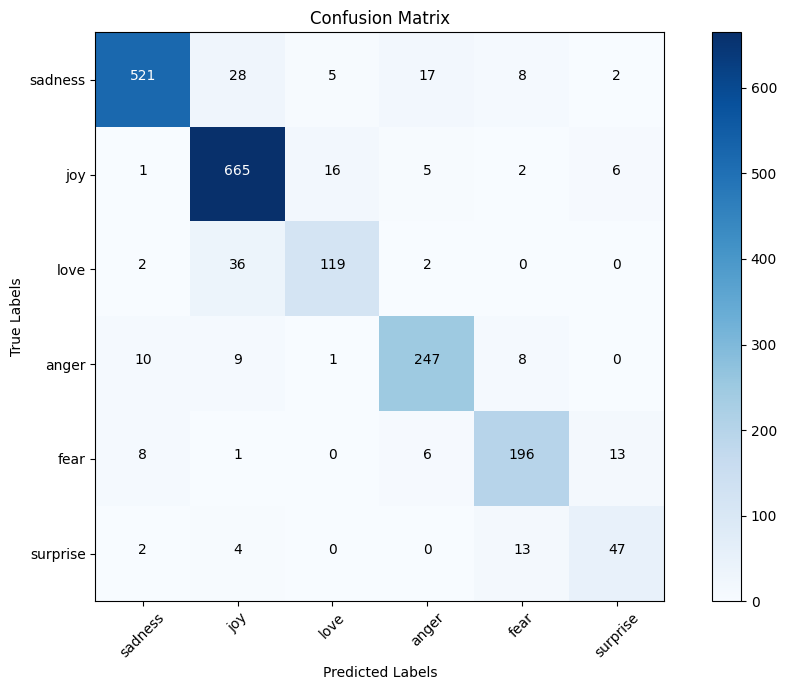

In [34]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'model', 'test_loader', 'DEVICE', and 'INDEX_TO_EMOTION' are defined
true_labels = []
predicted_labels = []

# Loop through the test set
for index in range(len(test_loader.dataset)):
    current_batch = test_loader.dataset[index]

    # Get the model prediction
    predicted = model(current_batch["input_ids"].unsqueeze(0).to(DEVICE)).argmax(dim=1).item()

    # Collect true and predicted labels
    true_labels.append(current_batch['labels'].item())
    predicted_labels.append(predicted)

# Get the number of classes (size of the emotion index)
num_classes = len(INDEX_TO_EMOTION)

# Initialize confusion matrix (num_classes x num_classes)
confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

# Populate the confusion matrix
for t, p in zip(true_labels, predicted_labels):
    confusion_matrix[t, p] += 1

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
plt.imshow(confusion_matrix, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()

# Labels and ticks
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, INDEX_TO_EMOTION.values(), rotation=45)
plt.yticks(tick_marks, INDEX_TO_EMOTION.values())

# Add labels to the matrix cells
thresh = confusion_matrix.max() / 2.
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(confusion_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_matrix[i, j] > thresh else "black")

# Axis labels
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()
